# Evaluating Search Suggester's Performance

In these scripts I evaluate [Search Suggester's](http://www.stevenamfelix.com) performance by the following steps:

1. Constructing 100 "pseudo-test queries" by retrieving 100 question titles from Stack Overflow API
2. Retrieving 5 "suggested" queries for each test query (now a total of (5+1)\*100 = 600 queries in play)
3. Submitting each query to a real [Stack Overflow](http://www.stackoverflow.com) search (so 600 searches in total)
4. Scraping relevent metrics from each search-results page:
  - **titles** of results on first page
  - \# **votes** for each result
  - \# **answers** for each result
5. Comparing results from each test query and its respective set of 5 suggested queries:
  - proportion of "overlapping" search results
  - average number of votes per result
  - average number of answers per result

In [11]:
# nlp / text processing tools
import gensim
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re
import html

from itertools import product
import numpy as np
import pandas as pd
from collections import defaultdict

# for conducting stack overflow search quries
import requests
from bs4 import BeautifulSoup
import time
from random import uniform

from scipy.spatial.distance import cosine

## Loading model

In [12]:
# load full model with softmax, CBOW, and no negative sampling
path = "/Users/stevenfelix/Documents/DataScience_local/Insight/Demo_App/flaskexample/models/"
file = 'model_full_50M_sg0_sz250_win5_min3_hs1_neg0'
model= gensim.models.word2vec.Word2Vec.load(path+file)

## Functions

#### Primary validation functions

In [13]:
def validate(test_queries, topn, model, dic, rmv_stop_words=True, return_tokens=True):
    """ given a set of test queries, returns relevant comparisons between results
    of the test queries and their respective suggested queries"""
    
    #all_results = defaultdict(dict)
    i = 0
    for q in test_queries:
        i+=1
        print('starting query {}: {}'.format(i, q))
        dic[q] = evaluate_query(q, topn, model, rmv_stop_words=rmv_stop_words, return_tokens=return_tokens)
        if dic[q] == None:
            print('query {} failed (KeyError)'.format(i))
            continue
        print('query {} completed'.format(i))
    return dic

def evaluate_query(orig_query, topn, model, rmv_stop_words, return_tokens):
    # improtant local varaibles
    orig_query_vec = clean(orig_query, rmv_stop_words=rmv_stop_words, return_tokens=return_tokens)

    # generate, rank, filter suggestions
    print('generating predictions')
    best_sugs = generate_alternatives(orig_query, topn, model)
    if best_sugs is None:
        return None
    
    # query each suggestion and scrape relevent metrics
    sug_q_results ={}
    for _,q in best_sugs:
        print('getting search results for \"{}\"'.format(q))
        sug_q_results[q] = get_query_results(q)
        time.sleep(uniform(3, 10))
    
    # get query results for original query
    print('getting search results for original: \"{}\"'.format(q))
    orig_q_results = {orig_query: get_query_results(orig_query_vec)}
    
    # get metrics
    print('making comparisons')
    summaries,orig_summaries = compare(sug_q_results, orig_q_results)
    
    # calculate average metrics
    # messy: (average [difference score between (average votes among unique titles)])
    avg_cosine_dist_dif_score = np.nanmean([summaries[k]['avg_cos_distance'] - 
                                  orig_summaries[k]['avg_cos_distance'] for k in summaries
                                    if (~np.isnan(summaries[k]['avg_cos_distance']) and 
                                        ~np.isnan(orig_summaries[k]['avg_cos_distance']))])
    avg_answers_dif_score = np.nanmean([summaries[k]['avg_unique_answers'] - 
                                  orig_summaries[k]['avg_unique_answers'] for k in summaries
                                    if (~np.isnan(summaries[k]['avg_unique_answers']) and 
                                        ~np.isnan(orig_summaries[k]['avg_unique_answers']))])
    avg_votes_dif_score = np.nanmean([summaries[k]['avg_unique_votes'] - 
                                orig_summaries[k]['avg_unique_votes'] for k in summaries
                                  if (~np.isnan(summaries[k]['avg_unique_votes']) and 
                                      ~np.isnan(orig_summaries[k]['avg_unique_votes']))])
    avg_unique_items = np.nanmean([summaries[k]['unique'] for k in summaries])
    avg_answers_dif_score = np.nanmean([summaries[k]['avg_unique_answers'] - 
                                     orig_summaries[k]['avg_unique_answers'] for k in summaries])
    
    avg_total_results_dif_score = np.nanmean([summaries[k]['total_results_dif'] for k in summaries])
    avg_concordance = np.nanmean([summaries[k]['concordance'] for k in summaries if ~np.isnan(summaries[k]['concordance'])])
    
    # store these metrics into dictionary
    results = {}
    orig_prob = model.score([orig_query_vec])[0]
    results['avg_cos_distance_dif_score'] = avg_cosine_dist_dif_score
    results['avg_unique_items'] = avg_unique_items
    results['avg_answers_dif_score'] = avg_answers_dif_score
    results['avg_votes_dif_score'] = avg_votes_dif_score
    results['avg_prob_dif_score'] = np.mean([np.exp(prob) for prob,_ in best_sugs])/np.exp(orig_prob)
    results['avg_total_results_dif_score'] = avg_total_results_dif_score
    results['avg_concordance'] = avg_concordance
    return results

** Text pre-processing**

In [14]:
""" text pre processing """
contractions = re.compile(r"'|-|\"") # contractions
symbols = re.compile(r'(\W+)', re.U) # all non alphanumeric
singles = re.compile(r'(\s\S\s)', re.I|re.U) # single character removal
seps = re.compile(r'\s+') # separators (any whitespace)
tokenizer = RegexpTokenizer(r'\w+') # tokens separated by white spice
stops = set(stopwords.words('english')) # list of english stop words

# cleaner (order matters)
def clean(text, rmv_stop_words=True, return_tokens=False): 
    text = text.lower()
    text = contractions.sub('', text)
    text = symbols.sub(r' \1 ', text)
    text = singles.sub(' ', text)
    text = seps.sub(' ', text)
    tokens = tokenizer.tokenize(text)     # tokenize
    if rmv_stop_words:
        tokens = [i for i in tokens if not i in stops] # remove stop words
        text = ' '.join(tokens)
    if return_tokens:
        return tokens
    return text

#### Generating suggested queries

In [15]:
""" These generate alternative queries and score them and filter them """
def generate_alternatives(query, n, model, rmv_stop_words=True, return_tokens=True):
    print('getting similar words')
    try:
        syns = get_similar(query, model, rmv_stop_words=rmv_stop_words, return_tokens=return_tokens) # synonyms
    except KeyError:
        return None
    print('making combinations')
    combs = get_combinations(syns) # combinations
    probs = [model.score([sug])[0] for sug in combs] # probabilities
    preds_probs =[(p,q) for p,q in zip(probs,combs)] # tuples of (suggestion, probability)
    preds_probs.sort(reverse=True) # sort by probability
    return preds_probs[0:n] # return top n

def get_similar(query, model, rmv_stop_words, return_tokens, threshold=.55):
    q = clean(query, rmv_stop_words=rmv_stop_words, return_tokens=return_tokens)
    d = [[x] for x in q] # turn each word  of query into its own list
    for x in d: # for each word in original query, add similar words to list
        x.extend([syn for syn,score in model.most_similar(x[0]) if score > threshold])
    return d

def get_combinations(l):
    combs = [x for x in product(*l)]
    return combs

#### conducting stack overflow searches and scraping results

In [16]:
"""These query stack overflow and return and parse the serach results for validation"""

headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36',
            'Accept': "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
            'Accept_Encoding': 'gzip, deflate, sdch, br', 'Accept_Language':'en-US,en;q=0.8',
            'Connection': 'keep-alive'}

def get_query_results(query):
    url = 'https://stackoverflow.com/search?q='+'+'.join(query)
    #print(url)
    r = requests.get(url)
    #print(r.status_code)
    soup = BeautifulSoup(r.text, 'lxml')
    try:
        total_results = soup.find("div", class_="subheader results-header").find('h2').get_text()
    except AttributeError:
        #print("Stack overflow doesn't bleive you're human. Click the link and refresh to verify:")
        #print(url)
        #input("Press Enter to continue...")
        print("***Stack overflow doesn't bleive you're human. Waiting 60 seconds and retrying***")
        time.sleep(60)
        r = requests.get(url)
        soup = BeautifulSoup(r.text, 'lxml')
        total_results = soup.find("div", class_="subheader results-header").find('h2').get_text()
    x = parse_results(soup, total_results, url)
    print('returned {} of {} results'.format(len(x['results_summary']), x['total_results']))
    return x
    
def parse_results(soup, total, url):
    results_dict = {}
    l =[]
    results_dict['total_results'] = int(re.match('\d*',total).group())
    results = soup.find_all("div", class_="question-summary search-result")
    i = 0
    for result in results:
        i += 1
        if i > 10:
            break
        votes = [v.get_text() for v in result.find_all("strong")]
        if len(votes) == 1:
            votes.append(1)
        link = result.find("div", class_="result-link").find('a')
        query = link.attrs['title']
        url = link.attrs['href']
        votes.extend([query,url])
        l.append(tuple(votes))
    results_dict['results_summary'] = l
    return results_dict

In [17]:
def compare(suggestions, original):
    """ given dictionaries of suggested-queries' results and the original/test query's results,
    compares metrics of the returned results"""
    
    # get result titles from original in a list
    orig_q = list(original)[0]
    orig_items = [title for _,_,title,_ in original[orig_q]['results_summary']]
    summaries = defaultdict(dict)
    orig_summaries = defaultdict(dict)
    for k in suggestions:
        # isolate titles for suggested results
        sug_items = [title for _,_,title,_ in suggestions[k]['results_summary']]
        # identify which results are shared with the original search results
        shared = set(orig_items) & set(sug_items)
        orig_unique = list(set(orig_items).difference(set(sug_items)))
        sug_unique = list(set(sug_items).difference(set(orig_items)))
        
        # sum total votes and answers on results page for unique results only
        votes,answers = sum_votes_answers(original[orig_q]['results_summary'], shared)
        orig_summaries[k]['avg_cos_distance'] = get_distances(orig_items, orig_q, model)
        orig_summaries[k]['unique'] = len(orig_unique)
        orig_summaries[k]['titles'] = orig_unique
        try: 
            # among the unique search results for the original query, what's the avg
            orig_summaries[k]['avg_unique_votes'] = votes*1.0/orig_summaries[k]['unique']
            orig_summaries[k]['avg_unique_answers'] = answers*1.0/orig_summaries[k]['unique']
        except ZeroDivisionError:
            orig_summaries[k]['avg_unique_votes'] = np.nan
            orig_summaries[k]['avg_unique_answers'] = np.nan
        
        # do the same for resultsfrom suggestions
        votes,answers = sum_votes_answers(suggestions[k]['results_summary'], shared)
        
        summaries[k]['avg_cos_distance'] = get_distances(sug_items, orig_q, model)
        summaries[k]['unique'] = len(sug_unique)
        summaries[k]['titles'] = sug_unique
        summaries[k]['total_results_dif'] = suggestions[k]['total_results'] - original[orig_q]['total_results']
        try:
            summaries[k]['concordance'] = len(shared)*1.0/len(sug_items)
        except ZeroDivisionError:
            summaries[k]['concordance'] = np.nan
        try: 
            summaries[k]['avg_unique_votes'] = votes*1.0/summaries[k]['unique']
            summaries[k]['avg_unique_answers'] = answers*1.0/summaries[k]['unique']
        except ZeroDivisionError:
            print('votes and answers zero division')
            summaries[k]['avg_unique_votes'] = np.nan
            summaries[k]['avg_unique_answers'] = np.nan
    return summaries, orig_summaries

def sum_votes_answers(page_summary, shared_results):
    votes = 0
    answers = 0
    for vote,answer,query,_ in page_summary:
            if query in shared_results:
                continue
            votes += int(vote)
            answers += int(answer)
    return votes,answers

def get_distances(items, original, model):
    if len(items) == 0:
        return np.nan
    original_vec = toks2vec(original.split(), model)
    dist = []
    for item in items:
        toks = clean(item, return_tokens=True)
        vec = toks2vec(toks, model)    
        dist.append(cosine(original_vec, vec))
    return np.nanmean(dist)

def toks2vec(tokens, model):
    s = 0.0
    for token in tokens:
        try: 
            s += model[token]
        except KeyError:
            s = s + np.nan
    return s # using sum or average makes no difference in cosine similarity

# Preparing test queries for validation

Here I used the stack overflow API via stackAPI to get titles of 100 posts. I will clean these and use them as test queries. Note, this is a biased test, but should be a conervativce test of search suggester, as it *should* guarantee at least one search result for each test query.

In [60]:
from stackapi import StackAPI
from datetime import datetime, timedelta

In [61]:
# create connection
SITE = StackAPI('stackoverflow')
SITE.page_size = 100
SITE.max_pages = 6

In [62]:
def get_attrib(posts, tag):
    return [d[tag] for d in posts['items']]

def append(filename, dat):    
    with open(filename, 'a+') as f:
        for item in dat:
            f.write(item+'\n')

In [63]:
posts = SITE.fetch('questions', fromdate=datetime(2010,1,1), todate=datetime(2016,1,1),
                                min=10)

In [64]:
print('Available Attributes: ')
list(posts['items'][0])

Available Attributes: 


['tags',
 'owner',
 'is_answered',
 'view_count',
 'accepted_answer_id',
 'answer_count',
 'score',
 'last_activity_date',
 'creation_date',
 'last_edit_date',
 'question_id',
 'link',
 'title']

In [65]:
def get_attrib(attrib):
    return [x[attrib] for x in posts['items']]

In [200]:
#[datetime.fromtimestamp(date) for date in get_attrib('creation_date')]

 - dates are randomly scattered between 2010 and 2015

In [ ]:
import json

with open(path+'posts_for_validation.txt', 'w') as outfile:
    json.dump(posts, outfile)

with open(path+'titles_for_validation.txt', 'w') as f:
    for title in get_attrib('title'):
        f.write(title+'\n')

# Validation

In [18]:
# load test queries, keep just 120 of them
path = '/Users/stevenfelix/Documents/DataScience_local/Insight/'

with open(path+'titles_for_validation.txt', 'r') as f:
    queries = f.readlines()

queries =[html.unescape(q).strip() for q in queries]

queries120 = queries[0:120]

Let's take a look at some of the test queries before and after processing. Note that the processing leads to a reasonable query-like input.

In [19]:
queries_clean_7 = []
for q in queries120:
    tok = clean(q, rmv_stop_words=True, return_tokens=True)
    if len(tok) > 7:
        continue
    queries_clean_7.append(' '.join(tok))
    print 

In [20]:
print(len(queries_clean_7))
queries_clean_7[0:10]

97


['install ror debian squeeze',
 'css line height bottom',
 'writing string file new line every time',
 'css lineheight alignment issues',
 'return 410 robots txt',
 'swift change button color pressed',
 'linked server cant start distributed transaction trigger',
 'lodash loop start value end value',
 'unable initialize mockhttpservletrequest unit tests',
 'add border top side uiview']

In [21]:
r = defaultdict(dict) # uncomment this only for the first pass
results = validate(queries_clean_7, topn=5, model=model, dic=r)

starting query 1: install ror debian squeeze
generating predictions
getting similar words
making combinations
getting search results for "('installing', 'rails', 'debian', 'wheezy')"
returned 8 of 8 results
getting search results for "('installing', 'rails', 'debian', 'squeeze')"
returned 10 of 19 results
getting search results for "('install', 'rails', 'debian', 'wheezy')"
returned 8 of 8 results
getting search results for "('installing', 'ror', 'debian', 'squeeze')"
returned 1 of 1 results
getting search results for "('install', 'rails', 'debian', 'squeeze')"
returned 10 of 19 results
getting search results for original: "('install', 'rails', 'debian', 'squeeze')"
returned 1 of 1 results
making comparisons
votes and answers zero division
query 1 completed
starting query 2: css line height bottom
generating predictions
getting similar words
making combinations
getting search results for "('css', 'line', 'height', 'bottom')"
***Stack overflow doesn't bleive you're human. Waiting 60 sec

/Users/stevenfelix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice
/Users/stevenfelix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
/Users/stevenfelix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/Users/stevenfelix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice


making combinations
getting search results for "('returns', '410', 'robots', 'txt')"
***Stack overflow doesn't bleive you're human. Waiting 60 seconds and retrying***
returned 0 of 0 results
getting search results for "('return', '410', 'robots', 'txt')"
returned 0 of 0 results
getting search results for "('returning', '410', 'robots', 'txt')"
returned 0 of 0 results
getting search results for "('returned', '410', 'robots', 'txt')"
returned 0 of 0 results
getting search results for "('returns', '410', 'cmakelists', 'txt')"
returned 0 of 0 results
getting search results for original: "('returns', '410', 'cmakelists', 'txt')"
returned 0 of 0 results
making comparisons
votes and answers zero division
votes and answers zero division
votes and answers zero division
votes and answers zero division
votes and answers zero division


/Users/stevenfelix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice


query 5 completed
starting query 6: swift change button color pressed
generating predictions
getting similar words
making combinations
getting search results for "('swift', 'change', 'button', 'color', 'clicked')"
returned 10 of 25 results
getting search results for "('swift', 'change', 'button', 'color', 'pressed')"
returned 10 of 17 results
getting search results for "('swift', 'change', 'button', 'color', 'clicking')"
returned 10 of 25 results
getting search results for "('swift', 'changing', 'button', 'color', 'clicked')"
returned 10 of 25 results
getting search results for "('swift', 'set', 'button', 'color', 'pressed')"
returned 5 of 5 results
getting search results for original: "('swift', 'set', 'button', 'color', 'pressed')"
returned 10 of 17 results
making comparisons
votes and answers zero division
query 6 completed
starting query 7: linked server cant start distributed transaction trigger
generating predictions
getting similar words
making combinations
getting search result

returned 10 of 439 results
getting search results for "('error', 'add', 'runnable', 'jar', 'eclipse')"
returned 10 of 1 results
getting search results for original: "('error', 'add', 'runnable', 'jar', 'eclipse')"
returned 10 of 1 results
making comparisons
votes and answers zero division
query 14 completed
starting query 15: android achartengine points yaxis
generating predictions
getting similar words
making combinations
getting search results for "('android', 'achartengine', 'point', 'yaxis')"
***Stack overflow doesn't bleive you're human. Waiting 60 seconds and retrying***
returned 0 of 0 results
getting search results for "('android', 'achartengine', 'points', 'yaxis')"
returned 0 of 0 results
getting search results for "('android', 'achartengine', 'point', 'axis')"
returned 5 of 5 results
getting search results for "('android', 'achartengine', 'points', 'axis')"
returned 5 of 5 results
getting search results for "('android', 'flot', 'point', 'xaxis')"
returned 0 of 0 results
gett

getting search results for "('tint', 'menus', 'icons')"
returned 10 of 64 results
getting search results for original: "('tint', 'menus', 'icons')"
returned 10 of 67 results
making comparisons
votes and answers zero division
votes and answers zero division
query 23 completed
starting query 24: getting additional data passworddata using seckeychainfindgenericpassword osx
generating predictions
getting similar words
query 24 failed (KeyError)
starting query 25: order calling constructors python
generating predictions
getting similar words
making combinations
getting search results for "('order', 'call', 'methods', 'python')"
***Stack overflow doesn't bleive you're human. Waiting 60 seconds and retrying***
returned 10 of 1 results
getting search results for "('order', 'called', 'methods', 'python')"
returned 10 of 1 results
getting search results for "('order', 'calling', 'methods', 'python')"
returned 10 of 449 results
getting search results for "('order', 'calls', 'methods', 'python')"


returned 0 of 0 results
getting search results for original: "('com', 'sun', 'jdi', 'invocationexception', 'occurred', 'call', 'function')"
returned 1 of 1 results
making comparisons
votes and answers zero division
votes and answers zero division
votes and answers zero division
votes and answers zero division
votes and answers zero division
query 33 completed
starting query 34: container_of inode i_cdev struct scull_dev cdev explanation
generating predictions
getting similar words
query 34 failed (KeyError)
starting query 35: generate self signed certificate fly
generating predictions
getting similar words
making combinations
getting search results for "('generated', 'self', 'signed', 'certificate', 'dynamically')"
***Stack overflow doesn't bleive you're human. Waiting 60 seconds and retrying***
returned 10 of 39 results
getting search results for "('create', 'self', 'signed', 'certificate', 'dynamically')"
returned 10 of 31 results
getting search results for "('creating', 'self', 'sig

making combinations


KeyboardInterrupt: 

**Note**: initializing the defaultdict <code>r</code> above and then passing it to <code>validate()</code> ensures that if an error occurs, the progress is not lost. You can restart the function by simply updating the items in <code>queries_clean_7</code> with the next cell, and then re-running <code>validate()</code> in the next cell.

In [26]:
queries_clean_7_mod = [q for q in queries_clean_7 if q not in list(r)]
print(len(queries_clean_7_mod))

54


In [27]:
queries_clean_7_mod.pop(0)

'insert picture excel vba method pictures failed'

In [30]:
results = validate(queries_clean_7_mod, topn=5, model=model, dic=r)

starting query 1: multiple keys keydown keyboard time
generating predictions
getting similar words
making combinations
getting search results for "('multiple', 'keys', 'keypress', 'keyboard', 'time')"
returned 10 of 18 results
getting search results for "('two', 'keys', 'keypress', 'keyboard', 'time')"
returned 10 of 32 results
getting search results for "('multiple', 'key', 'keypress', 'keyboard', 'time')"
returned 10 of 20 results
getting search results for "('multiple', 'keys', 'onkeyup', 'keyboard', 'time')"
returned 0 of 0 results
getting search results for "('multiple', 'keys', 'keydown', 'keyboard', 'time')"
returned 10 of 22 results
getting search results for original: "('multiple', 'keys', 'keydown', 'keyboard', 'time')"
returned 10 of 22 results
making comparisons
votes and answers zero division
votes and answers zero division
query 1 completed
starting query 2: java lambdas equivalent oftype
generating predictions
getting similar words
making combinations
getting search resu

/Users/stevenfelix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
/Users/stevenfelix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/Users/stevenfelix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice


making combinations
getting search results for "('calculate', 'age', 'years', 'months', 'months')"
returned 10 of 193 results
getting search results for "('calculate', 'age', 'months', 'years', 'months')"
returned 10 of 193 results
getting search results for "('calculate', 'age', 'months', 'months', 'years')"
returned 10 of 193 results
getting search results for "('calculate', 'age', 'year', 'year', 'month')"
returned 10 of 221 results
getting search results for "('calculate', 'age', 'month', 'year', 'year')"
returned 10 of 221 results
getting search results for original: "('calculate', 'age', 'month', 'year', 'year')"
returned 10 of 122 results
making comparisons
query 3 completed
starting query 4: define sealed class
generating predictions
getting similar words
making combinations
getting search results for "('declare', 'abstract', 'class')"
***Stack overflow doesn't bleive you're human. Waiting 60 seconds and retrying***
returned 10 of 4 results
getting search results for "('define'

returned 4 of 4 results
getting search results for "('calculation', 'age', 'mysql', 'innodb')"
returned 0 of 0 results
getting search results for "('calculating', 'age', 'mysql', 'innodb')"
returned 0 of 0 results
getting search results for "('calculate', 'age', 'postgresql', 'innodb')"
returned 0 of 0 results
getting search results for "('calculation', 'age', 'postgresql', 'innodb')"
returned 0 of 0 results
getting search results for original: "('calculation', 'age', 'postgresql', 'innodb')"
returned 4 of 4 results
making comparisons
votes and answers zero division
votes and answers zero division
votes and answers zero division
votes and answers zero division
votes and answers zero division
query 13 completed
starting query 14: unable get googlemap onmarkerclicklistener work
generating predictions
getting similar words
making combinations
getting search results for "('cant', 'get', 'googlemap', 'onmarkerclicklistener', 'work')"
returned 0 of 0 results
getting search results for "('can

/Users/stevenfelix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice
/Users/stevenfelix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice


making combinations
getting search results for "('limit', 'number', 'urls', 'display', 'codeigniter', 'pagination')"
returned 1 of 1 results
getting search results for "('limit', 'number', 'links', 'display', 'codeigniter', 'pagination')"
returned 1 of 1 results
getting search results for "('limit', 'number', 'links', 'show', 'codeigniter', 'pagination')"
returned 1 of 1 results
getting search results for "('limit', 'number', 'links', 'displaying', 'codeigniter', 'pagination')"
returned 1 of 1 results
getting search results for "('limit', 'number', 'link', 'display', 'codeigniter', 'pagination')"
returned 1 of 1 results
getting search results for original: "('limit', 'number', 'link', 'display', 'codeigniter', 'pagination')"
returned 1 of 1 results
making comparisons
query 21 completed
starting query 22: exclude null values using jsonbuilder groovy
generating predictions
getting similar words


/Users/stevenfelix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: Mean of empty slice


making combinations
getting search results for "('ignoring', 'null', 'values', 'using', 'jsonbuilder', 'groovy')"
returned 1 of 1 results
getting search results for "('exclude', 'null', 'value', 'use', 'jsonbuilder', 'groovy')"
returned 1 of 1 results
getting search results for "('ignoring', 'null', 'values', 'use', 'jsonbuilder', 'groovy')"
returned 1 of 1 results
getting search results for "('exclude', 'null', 'values', 'use', 'jsonbuilder', 'groovy')"
returned 1 of 1 results
getting search results for "('ignoring', 'null', 'value', 'use', 'jsonbuilder', 'groovy')"
returned 1 of 1 results
getting search results for original: "('ignoring', 'null', 'value', 'use', 'jsonbuilder', 'groovy')"
returned 1 of 1 results
making comparisons
votes and answers zero division
votes and answers zero division
query 22 completed
starting query 23: finding matching objects array objects
generating predictions
getting similar words
making combinations
getting search results for "('find', 'matching', 'el

returned 10 of 82 results
getting search results for "('get', 'object', 'property', 'within', 'another', 'object', 'javascript')"
returned 10 of 205 results
getting search results for "('get', 'object', 'properties', 'inside', 'another', 'object', 'javascript')"
returned 10 of 268 results
getting search results for "('retrieve', 'object', 'property', 'inside', 'another', 'object', 'javascript')"
returned 10 of 29 results
getting search results for original: "('retrieve', 'object', 'property', 'inside', 'another', 'object', 'javascript')"
returned 10 of 100 results
making comparisons
query 31 completed
starting query 32: apache mina reading iosession
generating predictions
getting similar words
making combinations
getting search results for "('apache', 'mina', 'extracting', 'iosession')"
***Stack overflow doesn't bleive you're human. Waiting 60 seconds and retrying***
returned 0 of 0 results
getting search results for "('apache', 'mina', 'writing', 'iosession')"
returned 1 of 1 results


returned 10 of 348 results
getting search results for "('inserting', 'empty', 'values', 'array')"
returned 10 of 1 results
getting search results for original: "('inserting', 'empty', 'values', 'array')"
returned 10 of 991 results
making comparisons
query 40 completed
starting query 41: strange problems nokogiri
generating predictions
getting similar words
making combinations
getting search results for "('strange', 'issue', 'nokogiri')"
***Stack overflow doesn't bleive you're human. Waiting 60 seconds and retrying***
returned 9 of 9 results
getting search results for "('weird', 'issue', 'nokogiri')"
returned 9 of 9 results
getting search results for "('strange', 'problem', 'nokogiri')"
returned 10 of 15 results
getting search results for "('strange', 'issues', 'nokogiri')"
returned 9 of 9 results
getting search results for "('strange', 'problems', 'nokogiri')"
returned 10 of 15 results
getting search results for original: "('strange', 'problems', 'nokogiri')"
returned 10 of 15 results


returned 0 of 0 results
getting search results for "('stop', 'pycharm', 'autocompleting', 'html', 'django', 'templates', 'tags')"
returned 1 of 1 results
getting search results for "('stop', 'pydev', 'autocompleting', 'html', 'django', 'templates', 'tags')"
returned 0 of 0 results
getting search results for "('prevent', 'pydev', 'autocompleting', 'html', 'django', 'templates', 'tags')"
returned 0 of 0 results
getting search results for original: "('prevent', 'pydev', 'autocompleting', 'html', 'django', 'templates', 'tags')"
returned 1 of 1 results
making comparisons
votes and answers zero division
votes and answers zero division
votes and answers zero division
votes and answers zero division
votes and answers zero division
query 50 completed
starting query 51: multiplicative persistence coderbyte javascript
generating predictions
getting similar words
making combinations
getting search results for "('multiplicative', 'persistence', 'coderbyte', 'javascript')"
***Stack overflow doesn't 

In [31]:
results_df = pd.DataFrame(r).T
results_df.describe()

,avg_answers_dif_score,avg_concordance,avg_cos_distance_dif_score,avg_prob_dif_score,avg_total_results_dif_score,avg_unique_items,avg_votes_dif_score
count,62.0,85.0,83.0,91.000000,91.0,91.0,62.000000
unique,60.0,42.0,66.0,91.000000,60.0,35.0,62.000000
top,1.5,1.0,0.0,14.464558,0.0,0.0,-1.235556
freq,2.0,19.0,18.0,1.000000,9.0,27.0,1.000000


In [32]:
results_df.mean()

avg_answers_dif_score          -0.265342
avg_concordance                 0.491833
avg_cos_distance_dif_score      0.125185
avg_prob_dif_score             57.166471
avg_total_results_dif_score   -16.365934
avg_unique_items                3.246154
avg_votes_dif_score            27.719182
dtype: float64

In [44]:
import seaborn as sns

In [61]:
x = results_df.avg_votes_dif_score.dropna()

In [70]:
x2 = list(x)

In [85]:
x2.sort()

In [86]:
x2

[-154.49791666666664,
 -81.59111111111112,
 -33.166666666666664,
 -32.61714285714286,
 -26.736111111111114,
 -17.253968253968253,
 -13.0,
 -8.5,
 -7.1499999999999995,
 -6.054761904761905,
 -5.700000000000001,
 -5.296666666666667,
 -3.5355555555555553,
 -3.45,
 -3.193333333333334,
 -3.071428571428571,
 -2.763888888888889,
 -2.5,
 -2.3333333333333335,
 -2.0500000000000003,
 -2.031111111111111,
 -2.0,
 -1.75,
 -1.7333333333333334,
 -1.5,
 -1.25,
 -1.2355555555555555,
 -0.8958333333333333,
 -0.5666666666666667,
 -0.5,
 -0.44027777777777777,
 -0.3703703703703704,
 -0.15,
 0.6,
 0.6833333333333333,
 0.7407407407407408,
 0.8666666666666666,
 0.9464285714285716,
 1.0,
 1.097142857142857,
 1.2285714285714286,
 1.3499999999999999,
 1.6276785714285715,
 2.0,
 2.3,
 2.966666666666667,
 7.25,
 8.555555555555555,
 9.337777777777777,
 10.13611111111112,
 14.691666666666668,
 15.9,
 17.00793650793651,
 27.220000000000006,
 28.56444444444444,
 64.1,
 141.61111111111111,
 211.28666666666672,
 213.256944

In [87]:
from scipy import stats

In [89]:
stats.ttest_1samp(x2,0)

Ttest_1sampResult(statistic=1.8402030661237154, pvalue=0.070604435075491773)

ValueError: color kwarg must have one color per dataset

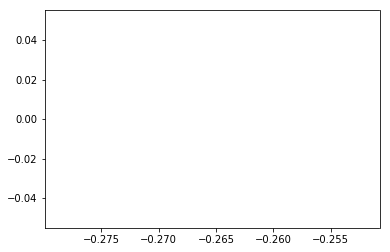

In [51]:
sns.distplot(results_df.avg_answers_dif_score.dropna())

In [212]:
# save results
results_df.to_csv(path+'validation_results_df_feb-4.csv')

suggestions:
 - have .73 LESS answers per result
 - lead to results with 26% overlap
 - are 29 times more probable
 - retrieve 6.19 fewer results
 - have ~4 unique items
 - have 20 more votes
 
Note: this method is skewed negatively -- the "original query" was derived from a real post, so it almost always will get a result, whereas the suggestions may not (sot he comparison will always be in favor of original)

- need to preprocess in a way that either keeps periods 'robots.txt' or always separates them
- algorithm also needs to exclude substitutsions that are terrible (ie lead to 0 results)
- sometimes removing words would be highly beneficial

returned 0 of 0 results
getting search results for "sklearn countvectorizer variables selected"
returned 0 of 0 results
getting search results for "sklearn countvectorizer variables multiselect"
returned 0 of 0 results
getting search results for "scikitlearn countvectorizer variable multiselect"
returned 0 of 0 results
getting search results for "scikitlearn countvectorizer variables multiselect"
returned 0 of 0 results

getting search results for "apache mina writing iosession"
returned 1 of 1 results
getting search results for "apache mina writing messagerecieved"
returned 0 of 0 results
getting search results for "apache mina writing executorfilter"
returned 0 of 0 results
getting search results for "apache mina read iosession"

getting search results for "know nodetool repair completed"
returned 6 of 6 results
getting search results for "tell nodetool repair completed"
returned 0 of 0 results
getting search results for "tell nodetool repair completes"
returned 0 of 0 results
getting search results for "determine nodetool repair completed"
returned 0 of 0 results
getting search results for "tell nodetool repair finished"
returned 1 of 1 results

In [49]:
path = "/Users/stevenfelix/Documents/DataScience_local/Insight/"
df = pd.read_csv(path+'validation_results_df.csv')
df.set_index('Unnamed: 0', inplace=True)
df.columns = ['Difference in answers per unique search result', 'Concordance', 
              'Suggestion probability ratio','Difference in total results', 'Avg Number Unique Items(out of 10)', 'Difference in votes per unique search result']

In [51]:
df

,Difference in answers per unique search result,Concordance,Suggestion probability ratio,Difference in total results,Avg Number Unique Items(out of 10),Difference in votes per unique search result
Unnamed: 0,,,,,,
install ror debian squeeze,-1.172222,0.240000,10.434649,10.00,6.80,0.227778
css line height bottom,-3.394841,0.100000,-0.773102,-0.75,9.00,-154.059127
writing string file new line every time,-0.300694,0.075000,0.138001,70.75,7.50,325.987500
css lineheight alignment issues,1.340000,NaN,3.757933,77.80,6.20,5.760000
return 410 robots txt,0.700000,NaN,166.547943,3.40,3.00,5.960000
swift change button color pressed,-1.640000,NaN,556.099670,-14.00,2.80,-0.560000
linked server cant start distributed transaction trigger,1.125000,NaN,0.194879,-0.25,0.75,-0.875000
lodash loop start value end value,-0.373333,0.000000,390.866699,7.00,5.60,0.126667
unable initialize mockhttpservletrequest unit tests,0.000000,NaN,0.376056,-1.00,0.00,0.000000


In [ ]:
df.mean()

In [ ]:
backup = defaultdict(dict)
results = validate(['looping through pandas dataframe'], n_syns=3, topn=1, model=model, dic=backup)

In [ ]:
results